In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Link to the dataset

https://www.kaggle.com/datasets/austinreese/usa-housing-listings

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('housing.csv')

In [5]:
df.shape

(384977, 22)

In [6]:
df.head(2)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7049044568,https://reno.craigslist.org/apa/d/reno-beautif...,reno / tahoe,https://reno.craigslist.org,1148,apartment,1078,3,2.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/01616_daghmBUvTC...,Ridgeview by Vintage is where you will find al...,39.5483,-119.796,ca
1,7049047186,https://reno.craigslist.org/apa/d/reno-reduced...,reno / tahoe,https://reno.craigslist.org,1200,condo,1001,2,2.0,0,...,0,0,0,w/d hookups,carport,https://images.craigslist.org/00V0V_5va0MkgO9q...,Conveniently located in the middle town of Ren...,39.5026,-119.789,ca


# 1. Data Cleaning

In [7]:
df.isnull().sum()

id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             79026
parking_options            140687
image_url                       0
description                     2
lat                          1918
long                         1918
state                           0
dtype: int64

### 1.1 fill null values

In [8]:
df['laundry_options'].fillna('no laundry on site', inplace=True)
df['parking_options'].fillna('no parking', inplace=True)
df['description'].fillna('no description', inplace=True)

In [9]:
df.isnull().sum()

id                            0
url                           0
region                        0
region_url                    0
price                         0
type                          0
sqfeet                        0
beds                          0
baths                         0
cats_allowed                  0
dogs_allowed                  0
smoking_allowed               0
wheelchair_access             0
electric_vehicle_charge       0
comes_furnished               0
laundry_options               0
parking_options               0
image_url                     0
description                   0
lat                        1918
long                       1918
state                         0
dtype: int64

### 1.2 filter out records outside of the USA

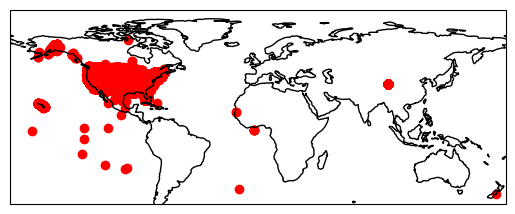

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

lats = df['lat'].values
lons = df['long'].values
ax.scatter(lons, lats, color='red', transform=ccrs.PlateCarree())

plt.show()


In [11]:
lat_min_main, lat_max_main = 24.396308, 49.384358
lon_min_main, lon_max_main = -125.0, -66.93457

lat_min_hawaii, lat_max_hawaii = 18.5, 22.5
lon_min_hawaii, lon_max_hawaii = -160, -154

df = df[
    ((df['lat'] >= lat_min_main) & 
     (df['lat'] <= lat_max_main) & 
     (df['long'] >= lon_min_main) & 
     (df['long'] <= lon_max_main)) |
    ((df['lat'] >= lat_min_hawaii) & 
     (df['lat'] <= lat_max_hawaii) & 
     (df['long'] >= lon_min_hawaii) & 
     (df['long'] <= lon_max_hawaii))
]


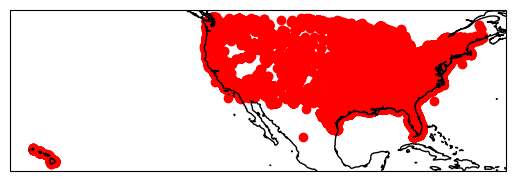

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

lats = df['lat'].values
lons = df['long'].values
ax.scatter(lons, lats, color='red', transform=ccrs.PlateCarree())

plt.show()

### 1.3. Drop columns that are meaningless for analysis

In [13]:
df.drop(columns=['url', 'region_url', 'image_url'], inplace=True)

In [14]:
df.isnull().sum()

id                         0
region                     0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
description                0
lat                        0
long                       0
state                      0
dtype: int64

### 1.4. Detect outliers

In [15]:
df['beds'].value_counts().sort_index()

beds
0        10836
1       116120
2       173539
3        66133
4        11394
5         2301
6          238
7           49
8           31
1000         2
1100         2
Name: count, dtype: int64

In [16]:
df = df[df['beds'] < 10]

In [17]:
"""
Fractional Bathroom Values Represent
Whole Numbers (e.g., 1.0, 2.0): Represent the count of full bathrooms.
Fractions (e.g., 1.5, 2.5): Represent a combination of full and half bathrooms:
A full bathroom typically includes a toilet, sink, and shower/tub.
A half bathroom (0.5) includes only a toilet and sink.
"""

df['baths'].value_counts() 

baths
1.0    195727
2.0    133499
1.5     27068
2.5     12934
3.0      5419
0.0      3067
4.0      1476
3.5      1003
4.5       223
5.0       130
5.5        57
6.0        26
7.0         4
6.5         4
7.5         2
8.5         1
8.0         1
Name: count, dtype: int64

In [27]:
# 1000 sqft = 92.9 m^2
# 15000 sqft = 1393 m^2

print('sqfeet min:', df['sqfeet'].min()) 
print('sqfeet 25th quantile', df['sqfeet'].quantile(0.25))
print('sqfeet median:', df['sqfeet'].median())
print('sqfeet 75th quantile', df['sqfeet'].quantile(0.75))
print('sqfeet max:', df['sqfeet'].max())

df = df[(df['sqfeet'] > 100) & (df['sqfeet'] < 15000)]

sqfeet min: 0
sqfeet 25th quantile 750.0
sqfeet median: 949.0
sqfeet 75th quantile 1150.0
sqfeet max: 14650


<Axes: xlabel='sqfeet', ylabel='Density'>

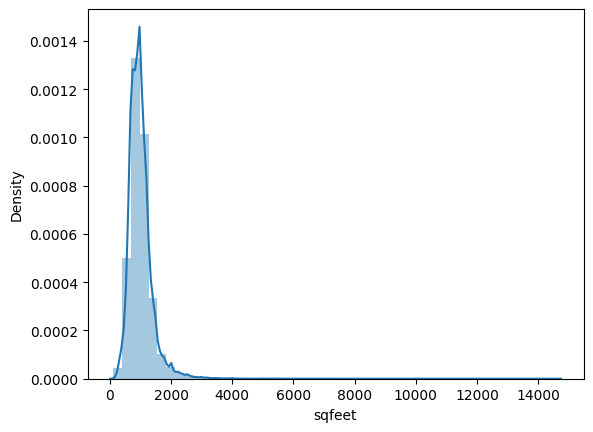

In [28]:
sns.distplot(df['sqfeet'])

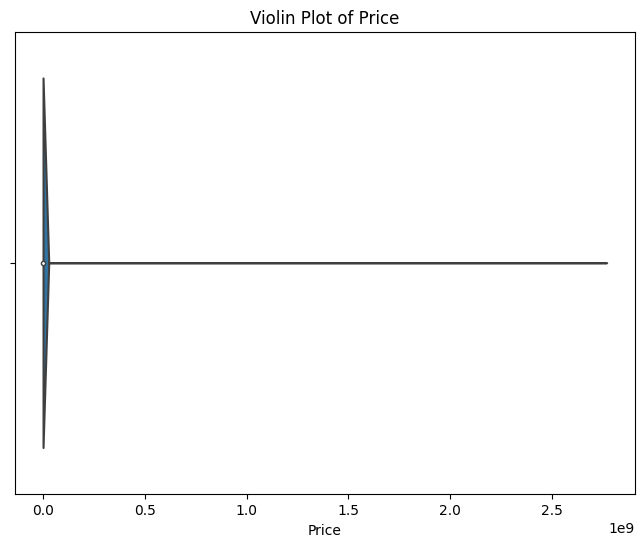

In [30]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['price'], inner='box')
plt.title('Violin Plot of Price')
plt.xlabel('Price')
plt.show()

In [31]:
df['price'].min(), df['price'].max()

(0, 2768307249)

In [40]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print('lower_bound:', lower_bound)
print('median:', df['price'].median())
print('upper_bound:', upper_bound)

quantile_1 = df['price'].quantile(0.01)
quantile_99 = df['price'].quantile(0.99)
print('quantile 1:', df['price'].quantile(0.01))
print('quantile 99:', df['price'].quantile(0.99))

df = df[(df['price'] >= quantile_1) & (df['price'] < quantile_99)]

Q1: 805.0, Q3: 1395.0, IQR: 590.0
lower_bound: -80.0
median: 1036.0
upper_bound: 2280.0
quantile 1: 349.0
quantile 99: 3395.0


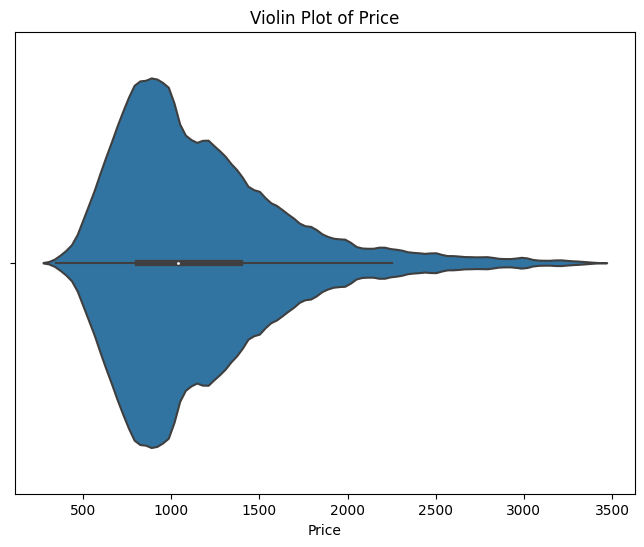

In [41]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['price'], inner='box')
plt.title('Violin Plot of Price')
plt.xlabel('Price')
plt.show()

# 2. Exploratory Data Analysis

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,371985.0,7.040980e+09,8.794442e+06,7.003808e+09,7.035985e+09,7.043314e+09,7.048418e+09,7.051292e+09
price,371985.0,1.160538e+03,4.907028e+02,3.490000e+02,8.130000e+02,1.036000e+03,1.390000e+03,3.394000e+03
sqfeet,371985.0,9.906481e+02,3.896579e+02,1.010000e+02,7.500000e+02,9.480000e+02,1.144000e+03,1.465000e+04
beds,371985.0,1.885845e+00,8.662559e-01,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,8.000000e+00
baths,371985.0,1.474659e+00,5.805257e-01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,7.500000e+00
cats_allowed,371985.0,7.324462e-01,4.426842e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
dogs_allowed,371985.0,7.125691e-01,4.525649e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
smoking_allowed,371985.0,7.357904e-01,4.409120e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
wheelchair_access,371985.0,8.116187e-02,2.730839e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
electric_vehicle_charge,371985.0,1.211877e-02,1.094163e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
